# Regional Tasmanian domain forced by GLORYS and ERA5 reanalysis datasets

**Note**: FRE-NC tools are required to be set up, as outlined in the [documentation](https://regional-mom6.readthedocs.io/en/latest/) of regional-mom6 package. You will also need to ensure that `matplotlib` is installed in your environment. If not, you can simply create a new cell and type `pip install matplotlib`

For this example we need:

- [GEBCO bathymetry](https://www.gebco.net/data_and_products/gridded_bathymetry_data/)
- [GLORYS ocean reanalysis data](https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/description)
- [ERA5 atmosphere data](https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5), and
- [TPXO tidal model data](https://www.tpxo.net/global)

This example reads in the entire global extent of ERA5 and GEBCO; we don't need to worry about cutting it down to size.

## What does the `regional_mom6` package do?

Setting up a regional model in MOM6 can be a pain. The goal of this package is that users should spend their debugging time fixing a model that's running and doing weird things, rather than puzzling over a model that won't even start.

In running this notebook, you'll hopefully have a running MOM6 regional model. There will still be a lot of fiddling to do with the `MOM_input` file to make sure that the parameters are set up right for your domain, and you might want to manually edit some of the input files. *But*, this package should help you bypass most of the woes of regridding, encoding and understanding the arcane arts of the MOM6 boundary segment files. 

## What does this notebook do?
This notebook is designed to set you up with a working MOM6 regional configuration. First, try to get it running with our default Tasmania case, then you can clone the notebook and modify for your region of interest. 

Input Type | Source | Subsets required
---|---|---
Surface | [ERA5 surface forcing](https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5) | Data from 2003; whole globe or subset around our domain
Ocean | [GLORYS reanalysis product](https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/description) | Boundary segments & initial condition; see section 2 for details.   
Bathymetry | [GEBCO](https://www.gebco.net/data_and_products/gridded_bathymetry_data/) | whole globe or subset around domain

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import regional_mom6 as rmom6

import os
from pathlib import Path
from dask.distributed import Client

client = Client()
client

# Currently, only the regional_mom6 module reports logging information to the info level, for more detailed output, uncomment the following:
# import logging
# logging.basicConfig(level=logging.INFO) 

## Step 1: Choose our domain, define workspace paths

To make sure that things are working I'd recommend starting with the default example defined below. If this runs ok, then change to a domain of your choice and hopefully it runs ok too! If not, check the [README](https://github.com/COSIMA/regional-mom6/blob/main/README.md) and [documentation](https://regional-mom6.readthedocs.io/) for troubleshooting tips.

You can log in and use [this GUI](https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/download) to find the lat/lon of your domain and copy paste below.

In [2]:
expt_name = "tasmania-example-reanalysis"

latitude_extent = [-48, -38.95]
longitude_extent = [143, 150]

date_range = ["2003-01-01 00:00:00", "2003-01-05 00:00:00"]

## Place where all your input files go 
input_dir = Path(f"mom6_input_directories/{expt_name}/")

## Directory where you'll run the experiment from
run_dir = Path(f"mom6_run_directories/{expt_name}/")

## Directory where compiled FRE tools are located (needed for construction of mask tables)
fre_tools_dir = Path("PATH_TO_FRE_TOOLS")

## Path to where your raw ocean forcing files are stored
glorys_path = Path("PATH_TO_GLORYS_DATA")

#Location of TPXO raw tidal file
#note that you will need to swap ## to the version number for each of the file names
tide_h_path = Path("PATH_TO_TPXO_H_FILE/h_tpxo##.nc")
tide_u_path = Path("PATH_TO_TPXO_U_FILE/u_tpxo##.nc")

## if directories don't exist, create them
for path in (run_dir, glorys_path, input_dir):
    os.makedirs(str(path), exist_ok=True)

## Step 2: Make experiment object
The `regional_mom6.experiment` contains the regional domain basics, and also generates the horizontal and vertical grids, `hgrid` and `vgrid` respectively, and sets up the directory structures. 

In [10]:
expt = rmom6.experiment(
    longitude_extent = longitude_extent,
    latitude_extent = latitude_extent,
    date_range = date_range,
    resolution = 0.05,
    number_vertical_layers = 75,
    layer_thickness_ratio = 60,
    depth = 4500,
    minimum_depth = 5,
    mom_run_dir = run_dir,
    mom_input_dir = input_dir,
    fre_tools_dir = fre_tools_dir,
    boundaries=["north", "south", "east", "west"]
)

We can now access the horizontal and vertical grid of the regional configuration via `expt.hgrid` and `expt.vgrid` respectively.

Plotting the vertical grid with `marker = '.'` lets you see the spacing. You can use `numpy.diff` to compute the vertical spacings, e.g.,
```python
import numpy as np
np.diff(expt.vgrid.zl).plot(marker = '.')
```
shows you the vertical spacing profile.

### Modular workflow!

After constructing your `expt` object, if you don't like the default `hgrid` and `vgrid` you can simply modify and then save them back into the `expt` object. However, you'll then also need to save them to disk again. For example:

```python
new_hgrid = xr.open_dataset(input_dir + "/hgrid.nc")
```
Modify `new_hgrid`, ensuring that _all metadata_ is retained to keep MOM6 happy. Then, save your changes

```python
expt.hgrid = new_hgrid

expt.hgrid.to_netcdf(input_dir + "/hgrid.nc")
```

## Step 3: Prepare ocean forcing data

We need to cut out our ocean forcing. The package expects an initial condition and one time-dependent segment per non-land boundary. Naming convention is `"east_unprocessed"` for segments and `"ic_unprocessed"` for the initial condition.

In this notebook, we are forcing with the Copernicus Marine "Glorys" reanalysis dataset. There's a function in the `mom6-regional` package that generates a bash script to download the correct boundary forcing files for your experiment. First, you will need to create an account with Copernicus, and you'll be prompted for your username and password when you try to run the bash script.

The function is called `get_glorys_rectangular` because the fully automated setup is only supported for domains with boundaries parallel to lines of longitude and latitude. To download more complex domain shapes you can call `rmom6.get_glorys_data` directly.

In [ ]:
expt.get_glorys(
    raw_boundaries_path=glorys_path
)

## Step 4: Set up bathymetry

Similarly to ocean forcing, we point the experiment's `setup_bathymetry` method at the location of the file of choice and also provide the variable names. We don't need to preprocess the bathymetry since it is simply a two-dimensional field and is easier to deal with. Afterwards you can inspect `expt.bathymetry` to have a look at the regional domain.

After running this cell, your input directory will contain other bathymetry-related things like the ocean mosaic and mask table too. The mask table defaults to a 10x10 layout and can be modified later.

In [ ]:
expt.setup_bathymetry(
    bathymetry_path='PATH_TO_GEBCO_FILE/GEBCO_2022.nc', 
    longitude_coordinate_name='lon',
    latitude_coordinate_name='lat',
    vertical_coordinate_name='elevation',
    )

### Check out your domain!

Calling `expt.bathymetry` returns an xarray dataset, which can be plotted as usual. If you haven't yet run setup_bathymetry, calling `expt.bathymetry` will return `None` and prompt you to do so!

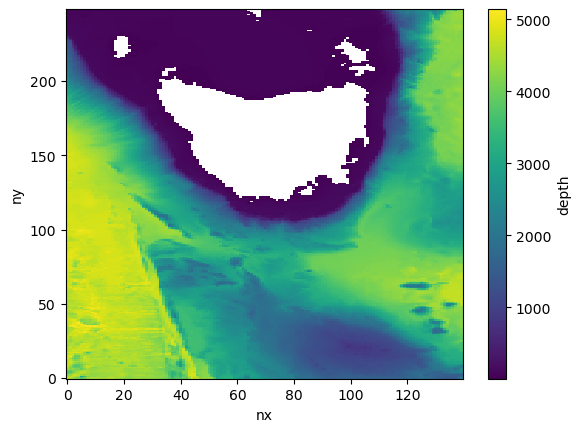

In [12]:
expt.bathymetry.depth.plot()

##  Step 5: Handle the ocean forcing - where the magic happens

This cuts out and interpolates the initial condition as well as all boundaries (unless you don't pass it boundaries).

The dictionary maps the MOM6 variable names to what they're called in your ocean input file. Notice how for GLORYS, the horizontal dimensions are `latitude` and `longitude`, vs `xh`, `yh`, `xq`, `yq` for MOM6. This is because for an 'A' grid type tracers share the grid with velocities so there's no difference.

If one of your segments is land, you can delete its string from the 'boundaries' list. You'll need to update MOM_input to reflect this though so it knows how many segments to look for, and their orientations.

In [ ]:
# Define a mapping from the GLORYS variables and dimensions to the MOM6 ones
ocean_varnames = {"time": "time",
                  "yh": "latitude",
                  "xh": "longitude",
                  "zl": "depth",
                  "eta": "zos",
                  "u": "uo",
                  "v": "vo",
                  "tracers": {"salt": "so", "temp": "thetao"}
                  }

# Set up the initial condition
expt.setup_initial_condition(
    glorys_path / "ic_unprocessed.nc", # directory where the unprocessed initial condition is stored, as defined earlier
    ocean_varnames,
    arakawa_grid="A"
    )    

# Set up the four boundary conditions. Remember that in the glorys_path, we have four boundary files names north_unprocessed.nc etc. 
expt.setup_ocean_state_boundaries(
        glorys_path,
        ocean_varnames,
        arakawa_grid = "A"
        )

### Check out your initial condition data

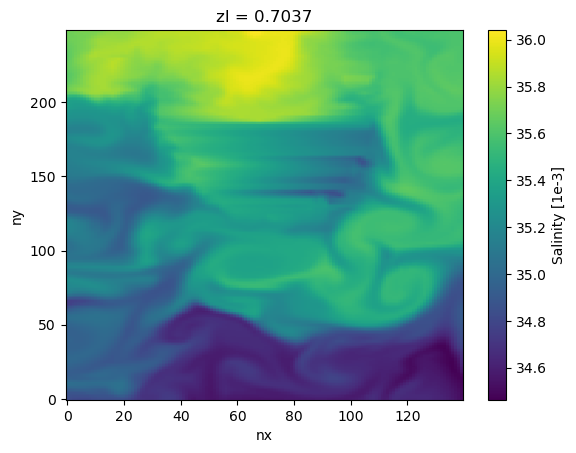

In [14]:
expt.init_tracers.salt.isel(zl = 0).plot()

### You can plot your segment data too

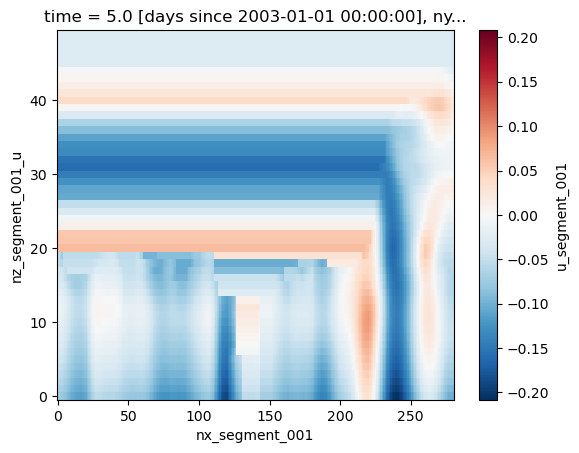

In [15]:
expt.segment_001.u_segment_001.isel(time = 5).plot()

## Step 6: Create tidal forcing

In [ ]:
# If you have downloaded the TPXO tidal data and wish to include tidal forcing at the boundary, run this cell
expt.setup_boundary_tides(
        tide_h_path,
        tide_u_path,
        tidal_constituents=["M2"],
)

## Step 7: Run the FRE tools

This is just a wrapper for the FRE tools needed to make the mosaics and masks for the experiment. The only thing you need to tell it is the processor layout. In this case we're saying that we want a 10 by 10 grid of 100 processors. 

In [ ]:
expt.run_FRE_tools(layout=(10, 10)) ## Here the tuple defines the processor layout

## Step 8: Set up ERA5 forcing:

Here we assume the ERA5 dataset is stored somewhere on the system we are working on. 

Below is a table showing ERA5 characteristics and what needs to be done to sort it out.

**Required ERA5 data**:

Name | ERA5 filename | ERA5 variable name | Units
---|---|---|---
Surface Pressure | sp | sp | Pa 
Surface Temperature | 2t | t2m | K 
Meridional Wind | 10v | v10 | m/s 
Zonal Wind | 10u | u10 | m/s 
Specific Humidity | - | - | kg/kg, calculated from dewpoint temperature
Dewpoint Temperature | 2d | d2m | K


We calculate specific humidity $q$ from dewpoint temperature $T_d$ and surface pressure $P$ via saturation vapour pressure $P_v$.

$$P_v = 10^{8.07131 - \frac{1730.63}{233.426 + T}} \frac{101325}{760} \; \textrm{[Pascal]} $$

$$q = 0.001 \times 0.622  \frac{P_v}{P}$$

In [18]:
expt.setup_era5("PATH_TO_ERA5_DATA/era5/single-levels/reanalysis")

## Step 9: Modify the default input directory to make a (hopefully) runnable configuration out of the box

This step copies the default directory and modifies the `MOM_layout` files to match your experiment by inserting the right number of x, y points and CPU layout.

To run MOM6 using the [payu infrastructure](https://github.com/payu-org/payu), provide the keyword argument `using_payu = True` to the `setup_run_directory` method and an example `config.yaml` file will be appear in the run directory. The `config.yaml` file needs to be modified manually to add the locations of executables, etc.

In [ ]:
expt.setup_run_directory(surface_forcing = "era5", with_tides = False)
# To turn on tides (assuming you ran step 6), set `with_tides = True`

## Step 10: Run and Troubleshoot!

To run the regional configuration first navigate to your run directory in terminal and use your favourite tool to run the experiment on your system. 

Ideally, MOM6 runs. If not, the first thing you should try is reducing the timestep. You can do this by adding `#override DT=XXXX` to your `MOM_override` file. 

If there's strange behaviour on your boundaries, you could play around with the `nudging timescale` (an example is already included in the `MOM_override` file). Sometimes, if your boundary has a lot going on (like all of the eddies spinning off the western boundary currents or off the Antarctic Circumpolar current), it can be hard to avoid these edge effects. This is because the chaotic, submesoscale structures developed within the regional domain won't match the flow at the boundary. 

Another thing that can go wrong is little bays that create non-advective cells at your boundaries. Keep an eye out for tiny bays where one side is taken up by a boundary segment. You can either fill them in manually, or move your boundary slightly to avoid them